In [2]:
!pip install lightgbm umap-learn scikit-learn pandas matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import umap
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import gc


In [5]:
df = pd.read_csv("/content/drive/MyDrive/bioinformatics/data analysis/final_dataset")
df.shape[0]

print(df.dtypes)
df.shape

<ipython-input-5-0f4f08bc6927>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/bioinformatics/data analysis/final_dataset")


GeneSymbol                         object
Origin                             object
Chromosome                         object
Start                               int64
NumberSubmitters                    int64
Grouped_ClinicalSignificance       object
is_frameshift                       int64
is_splice_site                      int64
is_missense                         int64
is_nonsense                         int64
is_synonymous                       int64
is_repeat_variant                   int64
type_Complex                         bool
type_Deletion                        bool
type_Duplication                     bool
type_Indel                           bool
type_Insertion                       bool
type_Inversion                       bool
type_Microsatellite                  bool
type_Tandem duplication              bool
type_Translocation                   bool
type_Variation                       bool
type_copy number gain                bool
type_copy number loss             

(6053974, 27)

In [6]:
df.duplicated().any()


np.False_

In [8]:
pd.set_option('display.max_rows', None)  # Show all rows in output

# Show value counts as a table
df['Grouped_ClinicalSignificance'].value_counts().to_frame().reset_index().rename(
    columns={'index': 'Grouped_ClinicalSignificance', 'Grouped_ClinicalSignificance': 'Count'}
)


,Count,count
0,Uncertain significance,3116243
1,Likely benign,1646185
2,Benign,488370
3,Pathogenic,294618
4,Conflicting classification of pathogenicity,268853
5,Likely pathogenic,239659
6,Risk allele,46


In [9]:
def clean_chromosome_column(df, col_name='Chromosome'):
    """
    Cleans and standardizes a Chromosome column for genomic data.

    Steps:
    - Convert all values to string
    - Strip whitespace
    - Replace numeric codes for X/Y/MT
    - Drop unknown/missing entries like 'na', 'NA', 'Un', 'UN', or blanks
    - Convert to categorical type
    """
    # Convert to string and strip
    df[col_name] = df[col_name].astype(str).str.strip()

    # Replace known alternate values

    df[col_name] = df[col_name].replace({
        '23': 'X',
        '24': 'Y',
        '25': 'MT',
        'na': 'NA',
        'NA': 'NA',
        'Un': 'UN',
        'UN': 'UN'
    })

    # Drop rows with unknown/missing chromosome values
    unknowns = ['NA', 'UN', '', 'nan']
    df = df[~df[col_name].isin(unknowns)].copy()

    # Convert to categorical
    df[col_name] = df[col_name].astype('category')

    return df
df = clean_chromosome_column(df, col_name='Chromosome')


In [10]:
df = df[df["Grouped_ClinicalSignificance"] != "risk allele"]

In [11]:
df.shape

(6053974, 27)

In [12]:
categorical_cols = [
    'GeneSymbol', 'Origin',
    'Grouped_ClinicalSignificance'
]
df[categorical_cols] = df[categorical_cols].astype('category')

In [13]:
df.duplicated().any()

np.False_

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df.drop_duplicates(inplace=True)


In [16]:
df2 = df.copy()
gene_freq = df2['GeneSymbol'].value_counts().to_dict()
df2['gene_freq'] = df2['GeneSymbol'].map(gene_freq)

# Hotspot Score (simple version): mark top N frequent genes as hotspots
top_n = 100  # You can adjust this threshold
hotspot_genes = df2['GeneSymbol'].value_counts().nlargest(top_n).index
df2['hotspot_score'] = df2['GeneSymbol'].isin(hotspot_genes).astype(int)

In [17]:
df2.dtypes

,0
GeneSymbol,category
Origin,category
Chromosome,category
Start,int64
NumberSubmitters,int64
Grouped_ClinicalSignificance,category
is_frameshift,int64
is_splice_site,int64
is_missense,int64
is_nonsense,int64


In [18]:
import numpy as np

# Copy df2 into df3 to preserve workflow
df3 = df2.copy()

# Normalize or log-scale NumberSubmitters
df3['submitter_score'] = np.log1p(df3['NumberSubmitters'])  # log(1 + x)

# Scale ReviewConfidence between 0-1 (if not already)
# If ReviewConfidence is already between 0-1, you can skip this step.
# Otherwise, normalize it using min-max scaling:
if df3['ReviewScore'].max() > 1:
    df3['review_score_norm'] = (df3['ReviewScore'] - df3['ReviewScore'].min()) / (df3['ReviewScore'].max() - df3['ReviewScore'].min())
else:
    df3['review_score_norm'] = df3['ReviewScore']

# Combine into a single confidence_score (weighted average or product)
df3['confidence_score'] = df3['submitter_score'] * df3['review_score_norm']


In [19]:
df3.dtypes

,0
GeneSymbol,category
Origin,category
Chromosome,category
Start,int64
NumberSubmitters,int64
Grouped_ClinicalSignificance,category
is_frameshift,int64
is_splice_site,int64
is_missense,int64
is_nonsense,int64


In [20]:
# List of variant flags
variant_flags = [
    'is_frameshift',
    'is_splice_site',
    'is_missense',
    'is_nonsense',
    'is_synonymous',
    'is_repeat_variant'
]

# You can just include them directly as input features later
# Optionally, calculate a summary statistic
df3['variant_flag_sum'] = df3[variant_flags].sum(axis=1)


In [21]:
# Attention Mechanism
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Multiply
class AttentionLayer(Layer):
    def __init__(self, attention_size=32):
        super(AttentionLayer, self).__init__()
        self.attention_size = attention_size
        self.dense1 = Dense(attention_size, activation='relu')
        self.dense2 = Dense(1, activation='sigmoid')  # Attention weights
        self.dense3 = Dense(attention_size, activation='sigmoid')  # Additional layer

    def call(self, inputs):
        x = self.dense1(inputs)
        attention_weights = self.dense2(x)
        weighted_input = Multiply()([inputs, attention_weights])
        transformed = self.dense3(weighted_input)
        return tf.reduce_sum(transformed, axis=1), attention_weights


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00


In [22]:
# Prepare variant flags as input to the attention layer
flag_data = df3[variant_flags].values  # Convert to numpy array
flag_data = flag_data.reshape(flag_data.shape[0], len(variant_flags), 1)  # Reshape for the attention layer

# Apply the attention layer
attention_layer = AttentionLayer(attention_size=8)  # Adjust attention_size as needed
attention_output, attention_weights = attention_layer(flag_data)

# Convert attention_output to a pandas DataFrame
attention_df = pd.DataFrame(attention_output.numpy(),
                            columns=[f'attention_output_{i}' for i in range(attention_output.shape[1])])

# Concatenate attention output with the original DataFrame
df3 = pd.concat([df3.reset_index(drop=True), attention_df.reset_index(drop=True)], axis=1)

# Display the first few rows of the DataFrame with attention output
print(df3.head())


  GeneSymbol            Origin Chromosome      Start  NumberSubmitters  \
0      AP5Z1  germline;unknown          7    4820844                 3   
1      AP5Z1  germline;unknown          7    4781213                 3   
2    FOXRED1          germline         11  126145284                 6   
3    FOXRED1          germline         11  126275389                 6   
4    FOXRED1          germline         11  126147412                 2   

  Grouped_ClinicalSignificance  is_frameshift  is_splice_site  is_missense  \
0                   Pathogenic              0               0            0   
1                   Pathogenic              0               0            0   
2                   Pathogenic              0               0            1   
3                   Pathogenic              0               0            1   
4            Likely pathogenic              0               0            1   

   is_nonsense  ...  confidence_score  variant_flag_sum  attention_output_0  \
0      

In [23]:
# Copy df3 to df4 for this step (optional)
df4 = df3.copy()
# Binary labels for variant classification
# Define pathogenic and benign categories
pathogenic_terms = ['Pathogenic', 'Likely pathogenic']
benign_terms = ['Benign', 'Likely benign']
df4['is_pathogenic'] = df4['Grouped_ClinicalSignificance'].isin(pathogenic_terms).astype(int)
df4['is_benign'] = df4['Grouped_ClinicalSignificance'].isin(benign_terms).astype(int)



In [24]:
# Bin genomic positions into windows (e.g., 1000 bp window)
window_size = 1000
df4['genomic_bin'] = (df4['Start'] // window_size).astype(int)

# Count pathogenic and benign variants in each (chromosome, bin)
bin_counts = df4.groupby(['Chromosome', 'genomic_bin'], observed=False)[['is_pathogenic', 'is_benign']].sum().reset_index()

# Rename for clarity
bin_counts.rename(columns={
    'is_pathogenic': 'nearby_pathogenic_count',
    'is_benign': 'nearby_benign_count'
}, inplace=True)

# Merge back to main dataframe
df4 = df4.merge(bin_counts, on=['Chromosome', 'genomic_bin'], how='left')

# Mark bins with high pathogenic load as hotspot regions
pathogenic_threshold = 10  # adjust as needed
df4['in_hotspot_region'] = (df4['nearby_pathogenic_count'] >= pathogenic_threshold).astype(int)


In [25]:
df4.dtypes

,0
GeneSymbol,category
Origin,category
Chromosome,category
Start,int64
NumberSubmitters,int64
Grouped_ClinicalSignificance,category
is_frameshift,int64
is_splice_site,int64
is_missense,int64
is_nonsense,int64


In [26]:
df4.shape

(6053974, 47)

In [27]:
!pip install lightgbm --quiet

In [28]:
from IPython import get_ipython
def _safe_get_ipython():
    """Safe way to get current IPython instance even in non-interactive environments."""
    try:
        return get_ipython()
    except NameError:
        return None

# The `_safe_get_ipython` utility function allows us to work around this issue,
# and proceed even if there is no IPython instance available.
if _safe_get_ipython() is not None:
    shell = _safe_get_ipython()
    if shell.has_trait('cache_transformer'):
        shell.cache_transformer = None
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [29]:
# 1. Define feature groups based on available columns
# --------------------------------------
categorical_cols = ['GeneSymbol', 'Chromosome', 'Origin']

# Variant type columns - use the exact column names from your dataframe
variant_types = [
    'type_Complex', 'type_Deletion', 'type_Duplication', 'type_Indel',
    'type_Insertion', 'type_Inversion', 'type_Microsatellite',
    'type_Tandem duplication', 'type_Translocation', 'type_Variation',
    'type_copy number gain', 'type_copy number loss', 'type_protein only',
    'type_single nucleotide variant'
]

context_cols = ['in_hotspot_region', 'genomic_bin', 'nearby_pathogenic_count', 'nearby_benign_count']
clinvar_meta = ['ReviewScore', 'review_score_norm', 'NumberSubmitters', 'submitter_score', 'confidence_score']
gene_info = ['gene_freq', 'hotspot_score']
variant_flags = ['is_frameshift', 'is_splice_site', 'is_missense', 'is_nonsense', 'is_synonymous', 'is_repeat_variant']
prediction_flags = ['is_pathogenic', 'is_benign']
attention_output_cols = [f'attention_output_{i}' for i in range(8)]

# Final feature list
feature_cols = (
    categorical_cols +
    variant_types +
    context_cols +
    gene_info +
    clinvar_meta +
    variant_flags +
    prediction_flags +
    attention_output_cols # Use attention_output_cols instead of attention_output
)

print(f"Using {len(feature_cols)} features for model training")


Using 44 features for model training


In [30]:
# --------------------------------------
# 2. Handle missing values
# --------------------------------------

# Check for missing values
print("Missing values before handling:")
print(df4[feature_cols].isnull().sum().sort_values(ascending=False).head(10))

# Handle missing values for each type of column

# 1. Fill categorical columns with 'Unknown'
for col in categorical_cols:
    if df4[col].isnull().sum() > 0:
        df4[col] = df4[col].fillna('Unknown')
        print(f"Filled {col} missing values with 'Unknown'")

# 2. Fill numerical columns with median
numerical_cols = (variant_types + context_cols + clinvar_meta +
                  gene_info + variant_flags + prediction_flags + attention_output_cols)

for col in numerical_cols:
    if df4[col].isnull().sum() > 0:
        median_value = df4[col].median()
        df4[col] = df4[col].fillna(median_value)
        print(f"Filled {col} missing values with median: {median_value}")

# 3. Fill boolean columns with False
bool_cols = [col for col in df4.columns if df4[col].dtype == bool]
for col in bool_cols:
    if df4[col].isnull().sum() > 0:
        df4[col] = df4[col].fillna(False)
        print(f"Filled {col} missing values with False")


Missing values before handling:
GeneSymbol             0
Chromosome             0
Origin                 0
type_Complex           0
type_Deletion          0
type_Duplication       0
type_Indel             0
type_Insertion         0
type_Inversion         0
type_Microsatellite    0
dtype: int64


In [31]:
# Verify no missing values remain
print("\nMissing values after handling:")
print(df4[feature_cols].isnull().sum().sum())



Missing values after handling:
0


In [36]:
# --------------------------------------
# 3. Remove very rare class
# --------------------------------------
if 'Risk allele' in df4['Grouped_ClinicalSignificance'].unique():
    print("Removing rare 'Risk allele' class")
    df4_filtered = df4[df4['Grouped_ClinicalSignificance'] != 'Risk allele']
else:
    print("No 'Risk allele' class found in dataset")
    df4_filtered = df4


Removing rare 'Risk allele' class


In [37]:
df4.shape

(6053974, 47)

In [41]:
print(df4_filtered['Grouped_ClinicalSignificance'].unique())


['Pathogenic', 'Likely pathogenic', 'Conflicting classification of pathogenicity', 'Uncertain significance', 'Benign', 'Likely benign']
Categories (7, object): ['Benign', 'Conflicting classification of pathogenicity',
                         'Likely benign', 'Likely pathogenic', 'Pathogenic', 'Risk allele',
                         'Uncertain significance']


In [42]:
df4_filtered = df4[df4['Grouped_ClinicalSignificance'] != 'Risk allele'].copy()
df4_filtered['Grouped_ClinicalSignificance'] = df4_filtered['Grouped_ClinicalSignificance'].cat.remove_unused_categories()


In [44]:
print(df4_filtered['Grouped_ClinicalSignificance'].unique())


['Pathogenic', 'Likely pathogenic', 'Conflicting classification of pathogenicity', 'Uncertain significance', 'Benign', 'Likely benign']
Categories (6, object): ['Benign', 'Conflicting classification of pathogenicity',
                         'Likely benign', 'Likely pathogenic', 'Pathogenic',
                         'Uncertain significance']


In [45]:
df4_filtered.shape

(6053928, 47)

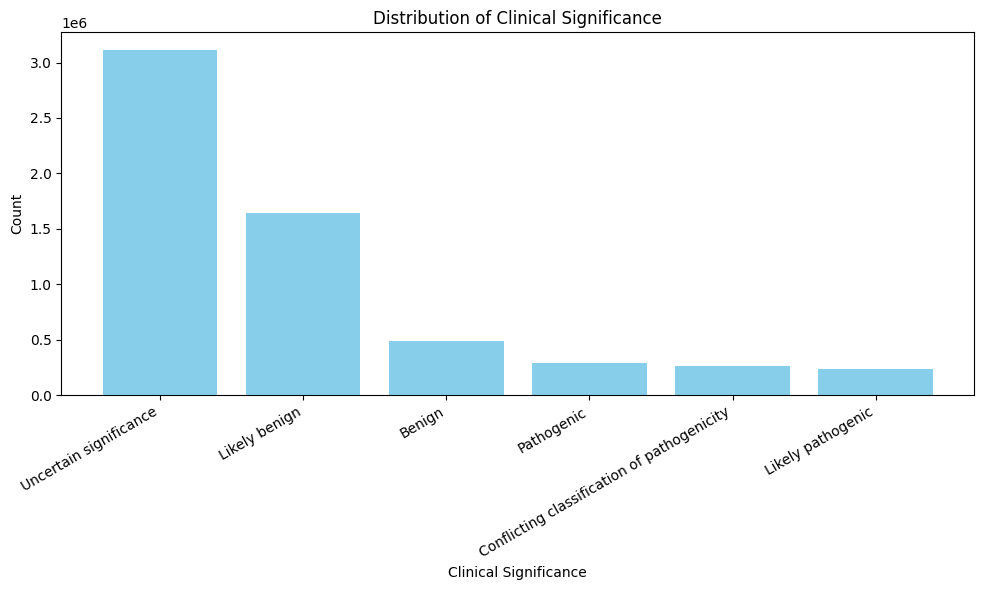

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df and the column is named 'ClinicalSignificance'
value_counts = df4_filtered['Grouped_ClinicalSignificance'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(value_counts.index, value_counts.values, color='skyblue')
plt.title('Distribution of Clinical Significance')
plt.xlabel('Clinical Significance')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.tight_layout()
plt.show()



In [47]:
# --------------------------------------
# 4. Define features and targets
# --------------------------------------
X = df4_filtered[feature_cols]
y_main = df4_filtered['Grouped_ClinicalSignificance']  # Multi-class target
y_aux = df4_filtered['ReviewScore']  # Regression target

# Ensure y_main is categorical
if not hasattr(y_main, 'cat'):
    print("Converting classification target to categorical")
    y_main = y_main.astype('category')


Starting 5-fold cross-validation...
Processing fold 1/5


<ipython-input-48-5e43dc3b05b3>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-48-5e43dc3b05b3>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.770433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11204
[LightGBM] [Info] Number of data points in the train set: 4843142, number of used features: 41
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-48-5e43dc3b05b3>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-48-5e43dc3b05b3>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.669098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11231
[LightGBM] [Info] Number of data points in the train set: 4843142, number of used features: 42
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-48-5e43dc3b05b3>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-48-5e43dc3b05b3>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.601987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11217
[LightGBM] [Info] Number of data points in the train set: 4843142, number of used features: 41
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-48-5e43dc3b05b3>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-48-5e43dc3b05b3>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.738626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11217
[LightGBM] [Info] Number of data points in the train set: 4843143, number of used features: 40
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-48-5e43dc3b05b3>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-48-5e43dc3b05b3>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.634282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 4843143, number of used features: 40
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

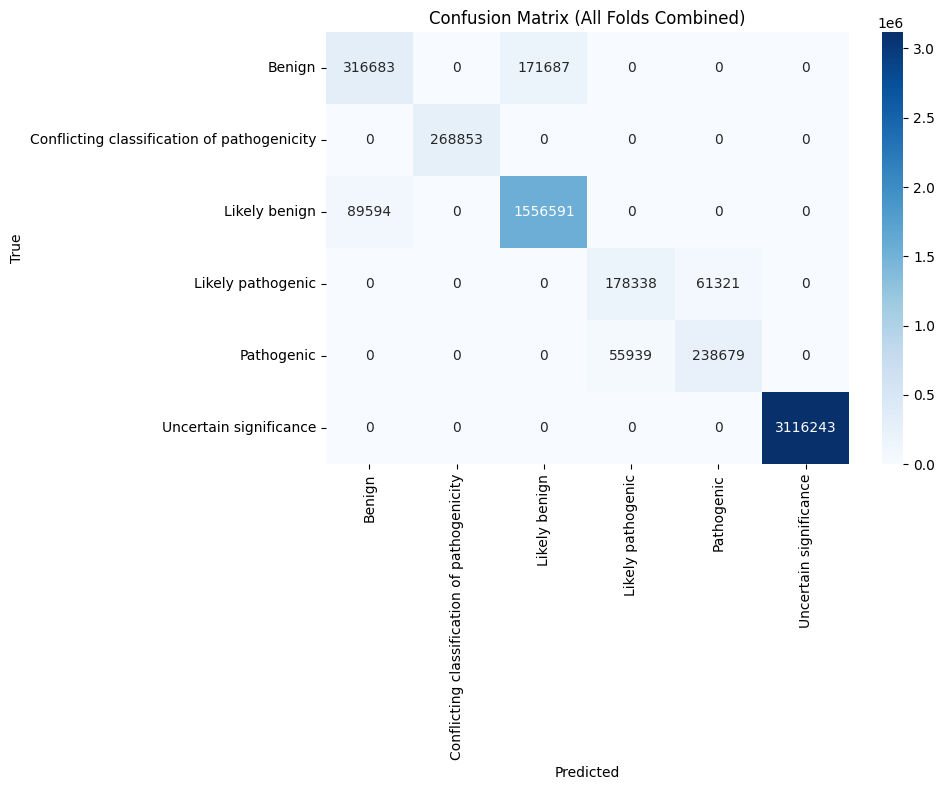


===== Training Final Model on Entire Dataset =====


<ipython-input-48-5e43dc3b05b3>:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.820639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11113
[LightGBM] [Info] Number of data points in the train set: 6053928, number of used features: 41
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

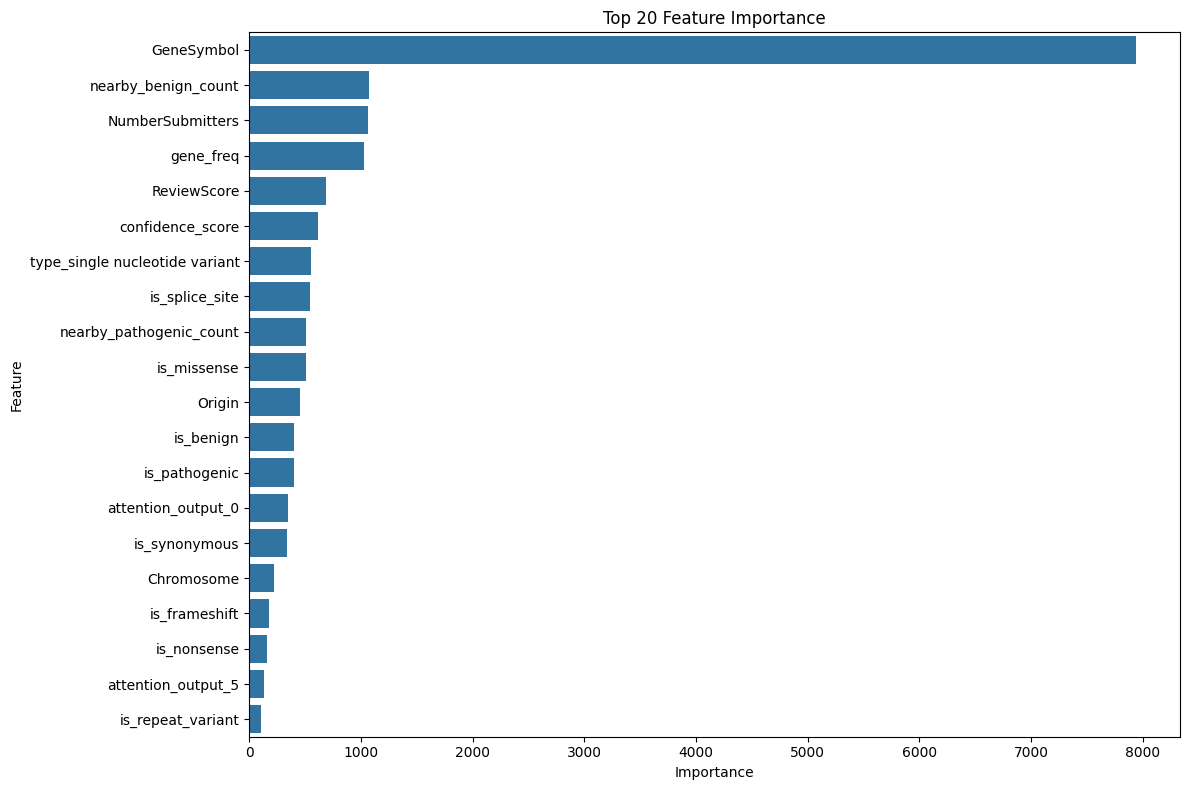

In [48]:
# # --------------------------------------
# # 5. Split data
# # --------------------------------------
# X_train, X_test, y_train_main, y_test_main, y_train_aux, y_test_aux = train_test_split(
#     X, y_main, y_aux, test_size=0.2, random_state=42, stratify=y_main
# )

# Import necessary libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd
import lightgbm as lgb
import time

# Define parameters for the classifier
clf_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_main)),  # Make sure this is based on the full dataset
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9
}

# Initialize arrays to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
training_times = []
inference_times = []

# Initialize 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store predictions and true labels for confusion matrix
all_y_true = []
all_y_pred = []

print("Starting 5-fold cross-validation...")

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_main)):
    print(f"Processing fold {fold+1}/5")

    # Split data for this fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_main.iloc[train_idx], y_main.iloc[test_idx]

    # Set categorical features
    for col in categorical_cols:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

    # Create and train model
    model = lgb.LGBMClassifier(**clf_params)

    # Measure training time
    train_start = time.time()
    model.fit(X_train, y_train)
    train_end = time.time()
    training_time = train_end - train_start
    training_times.append(training_time)

    # Measure inference time
    inference_start = time.time()
    y_pred = model.predict(X_test)
    inference_end = time.time()
    inference_time = inference_end - inference_start
    inference_times.append(inference_time)

    # Store predictions and true values for later use
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calculate and store metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    print(f"Fold {fold+1} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print(f"Fold {fold+1} - Training time: {training_time:.2f}s, Inference time: {inference_time:.6f}s")

# Calculate mean and standard deviation of metrics
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

mean_training_time = np.mean(training_times)
mean_inference_time = np.mean(inference_times)

# Print cross-validation results
print("\n===== Cross-Validation Results =====")
print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Average Training Time: {mean_training_time:.2f}s")
print(f"Average Inference Time: {mean_inference_time:.6f}s")

# Generate a classification report based on all folds combined
class_names = np.unique(y_main).tolist()
print("\n===== Classification Report (All Folds) =====")
print(classification_report(all_y_true, all_y_pred, target_names=class_names))

# Calculate confusion matrix using all folds combined
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_y_true, all_y_pred)
print("\n===== Confusion Matrix (All Folds) =====")
print(cm)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (All Folds Combined)')
plt.tight_layout()
plt.show()

# Train a final model on the entire dataset (optional)
print("\n===== Training Final Model on Entire Dataset =====")
final_model = lgb.LGBMClassifier(**clf_params)

# Set categorical columns
for col in categorical_cols:
    X[col] = X[col].astype('category')

final_train_start = time.time()
final_model.fit(X, y_main)
final_train_end = time.time()
print(f"Final model trained in {final_train_end - final_train_start:.2f}s")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n===== Top 15 Important Features =====")
print(feature_importance.head(15))

# Optional: Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# For multiclass classification, we need to calculate TP, TN, FP, FN for each class
print("\n===== True Positives, False Positives, False Negatives, True Negatives =====")

# Number of classes
n_classes = len(class_names)

# Initialize arrays to store metrics for each class
tp = np.zeros(n_classes, dtype=int)
fp = np.zeros(n_classes, dtype=int)
fn = np.zeros(n_classes, dtype=int)
tn = np.zeros(n_classes, dtype=int)

# Calculate metrics for each class
for i in range(n_classes):
    tp[i] = int(cm[i, i])  # Elements on the diagonal are true positives
    fp[i] = int(np.sum(cm[:, i]) - cm[i, i])  # Sum of column minus TP
    fn[i] = int(np.sum(cm[i, :]) - cm[i, i])  # Sum of row minus TP
    tn[i] = int(np.sum(cm) - tp[i] - fp[i] - fn[i])  # All remaining elements

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': class_names,
    'True Positives': tp,
    'False Positives': fp,
    'False Negatives': fn,
    'True Negatives': tn
})

print(metrics_df)

# Calculate overall metrics (sum across all classes)
total_tp = int(np.sum(tp))
total_fp = int(np.sum(fp))
total_fn = int(np.sum(fn))
total_tn = int(np.sum(tn) / n_classes)  # Divide by n_classes to avoid double counting

print("\n===== Overall Metrics =====")
print(f"Total True Positives: {total_tp}")
print(f"Total False Positives: {total_fp}")
print(f"Total False Negatives: {total_fn}")
print(f"Total True Negatives: {total_tn}")






===== True Positives, False Positives, False Negatives, True Negatives =====
                                         Class  True Positives  \
0                                       Benign          317282   
1  Conflicting classification of pathogenicity          268853   
2                                Likely benign         1556087   
3                            Likely pathogenic          178365   
4                                   Pathogenic          238783   
5                       Uncertain significance         3116243   

   False Positives  False Negatives  True Negatives  
0            90098           171088         5475460  
1                0                0         5785075  
2           171088            90098         4236655  
3            55835            61294         5758434  
4            61294            55835         5698016  
5                0                0         2937685  

===== Overall Metrics =====
Total True Positives: 5675613
Total False Positives:

***Using 10 cross Fold***

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-44-c49e3520b90d>:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Copy of final_dataset")


GeneSymbol                         object
Origin                             object
Chromosome                         object
Start                               int64
NumberSubmitters                    int64
Grouped_ClinicalSignificance       object
is_frameshift                       int64
is_splice_site                      int64
is_missense                         int64
is_nonsense                         int64
is_synonymous                       int64
is_repeat_variant                   int64
type_Complex                         bool
type_Deletion                        bool
type_Duplication                     bool
type_Indel                           bool
type_Insertion                       bool
type_Inversion                       bool
type_Microsatellite                  bool
type_Tandem duplication              bool
type_Translocation                   bool
type_Variation                       bool
type_copy number gain                bool
type_copy number loss             

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.796426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11156
[LightGBM] [Info] Number of data points in the train set: 5448535, number of used features: 42
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.836014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11205
[LightGBM] [Info] Number of data points in the train set: 5448535, number of used features: 41
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.693890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11158
[LightGBM] [Info] Number of data points in the train set: 5448535, number of used features: 41
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.734968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11179
[LightGBM] [Info] Number of data points in the train set: 5448535, number of used features: 40
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.731367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11191
[LightGBM] [Info] Number of data points in the train set: 5448535, number of used features: 42
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.717459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11172
[LightGBM] [Info] Number of data points in the train set: 5448535, number of used features: 41
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.689997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11158
[LightGBM] [Info] Number of data points in the train set: 5448535, number of used features: 40
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.743814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11090
[LightGBM] [Info] Number of data points in the train set: 5448535, number of used features: 40
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.680529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11197
[LightGBM] [Info] Number of data points in the train set: 5448536, number of used features: 40
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

<ipython-input-44-c49e3520b90d>:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-44-c49e3520b90d>:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.687527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11127
[LightGBM] [Info] Number of data points in the train set: 5448536, number of used features: 40
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

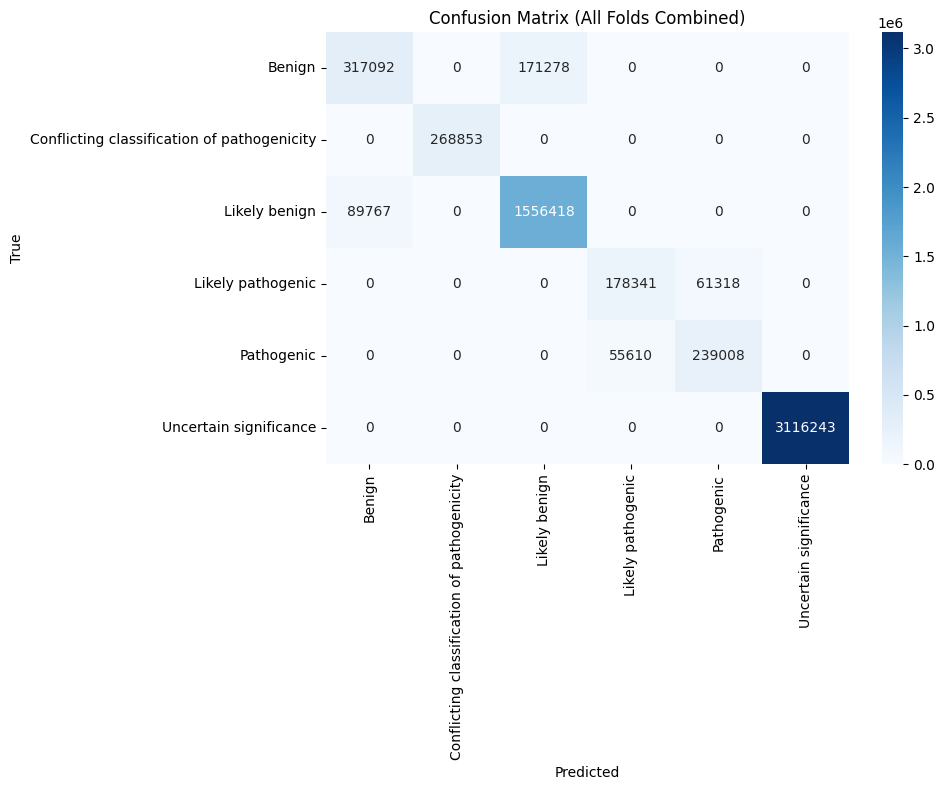


===== Training Final Model on Entire Dataset =====


<ipython-input-44-c49e3520b90d>:479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.722046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11112
[LightGBM] [Info] Number of data points in the train set: 6053928, number of used features: 41
[LightGBM] [Info] Start training from score -2.517389
[LightGBM] [Info] Start trainin

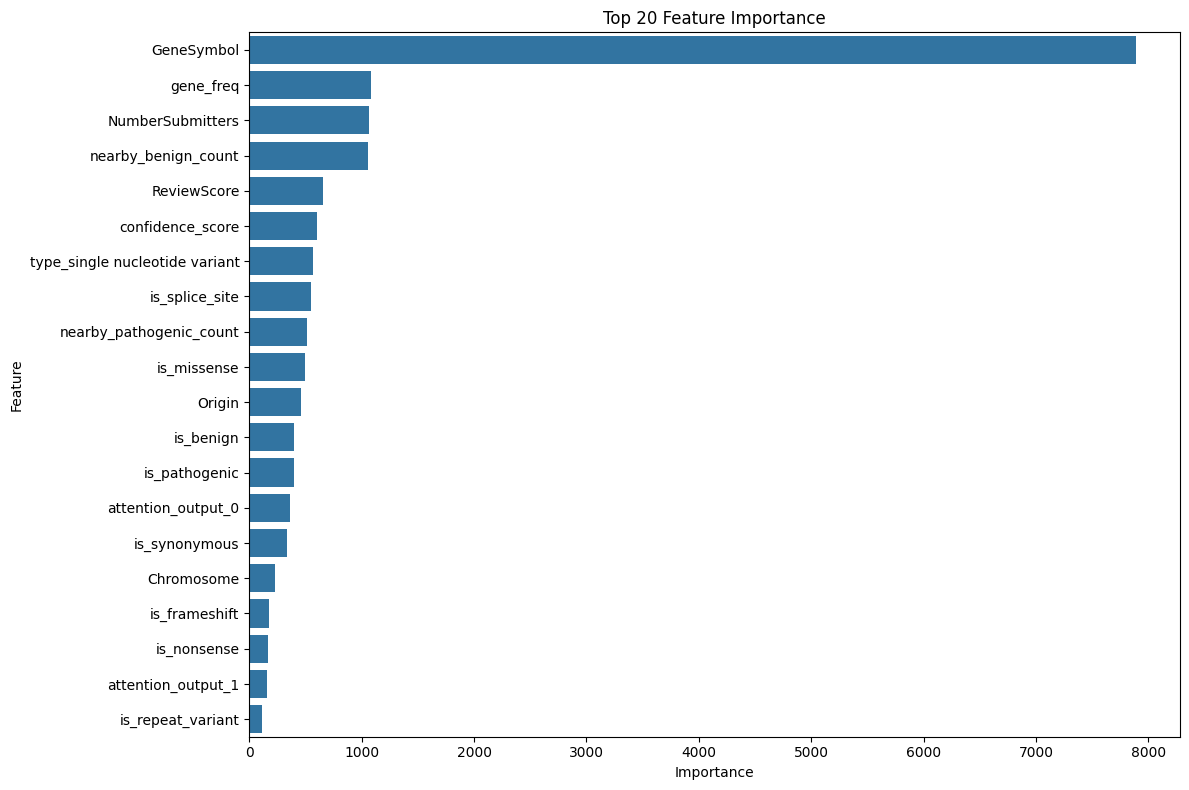


===== True Positives, False Positives, False Negatives, True Negatives =====
                                         Class  True Positives  \
0                                       Benign          317092   
1  Conflicting classification of pathogenicity          268853   
2                                Likely benign         1556418   
3                            Likely pathogenic          178341   
4                                   Pathogenic          239008   
5                       Uncertain significance         3116243   

   False Positives  False Negatives  True Negatives  
0            89767           171278         5475791  
1                0                0         5785075  
2           171278            89767         4236465  
3            55610            61318         5758659  
4            61318            55610         5697992  
5                0                0         2937685  

===== Overall Metrics =====
Total True Positives: 5675955
Total False Positives:

In [ ]:
!pip install lightgbm umap-learn scikit-learn pandas matplotlib --quiet

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import lightgbm as lgb
import umap
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import gc


df = pd.read_csv("/content/drive/MyDrive/Copy of final_dataset")
df.shape[0]

print(df.dtypes)
df.shape

df.duplicated().any()



df.duplicated().sum()


pd.set_option('display.max_rows', None)  # Show all rows in output

# Show value counts as a table
df['Grouped_ClinicalSignificance'].value_counts().to_frame().reset_index().rename(
    columns={'index': 'Grouped_ClinicalSignificance', 'Grouped_ClinicalSignificance': 'Count'}
)


df.drop_duplicates(inplace=True)


df.isnull().any().any()



df.duplicated().sum()


def clean_chromosome_column(df, col_name='Chromosome'):
    """
    Cleans and standardizes a Chromosome column for genomic data.

    Steps:
    - Convert all values to string
    - Strip whitespace
    - Replace numeric codes for X/Y/MT
    - Drop unknown/missing entries like 'na', 'NA', 'Un', 'UN', or blanks
    - Convert to categorical type
    """
    # Convert to string and strip
    df[col_name] = df[col_name].astype(str).str.strip()

    # Replace known alternate values
    df[col_name] = df[col_name].replace({
        '23': 'X',
        '24': 'Y',
        '25': 'MT',
        'na': 'NA',
        'NA': 'NA',
        'Un': 'UN',
        'UN': 'UN'
    })

    # Drop rows with unknown/missing chromosome values
    unknowns = ['NA', 'UN', '', 'nan']
    df = df[~df[col_name].isin(unknowns)].copy()

    # Convert to categorical
    df[col_name] = df[col_name].astype('category')

    return df
df = clean_chromosome_column(df, col_name='Chromosome')


df = df[df["Grouped_ClinicalSignificance"] != "risk allele"]

categorical_cols = [
    'GeneSymbol', 'Origin',
    'Grouped_ClinicalSignificance'
]
df[categorical_cols] = df[categorical_cols].astype('category')

df.duplicated().any()

df.duplicated().sum()

df.drop_duplicates(inplace=True)


df2 = df.copy()
gene_freq = df2['GeneSymbol'].value_counts().to_dict()
df2['gene_freq'] = df2['GeneSymbol'].map(gene_freq)

# Hotspot Score (simple version): mark top N frequent genes as hotspots
top_n = 100  # You can adjust this threshold
hotspot_genes = df2['GeneSymbol'].value_counts().nlargest(top_n).index
df2['hotspot_score'] = df2['GeneSymbol'].isin(hotspot_genes).astype(int)

df2.dtypes

import numpy as np

# Copy df2 into df3 to preserve workflow
df3 = df2.copy()

# Normalize or log-scale NumberSubmitters
df3['submitter_score'] = np.log1p(df3['NumberSubmitters'])  # log(1 + x)

# Scale ReviewConfidence between 0-1 (if not already)
# If ReviewConfidence is already between 0-1, you can skip this step.
# Otherwise, normalize it using min-max scaling:
if df3['ReviewScore'].max() > 1:
    df3['review_score_norm'] = (df3['ReviewScore'] - df3['ReviewScore'].min()) / (df3['ReviewScore'].max() - df3['ReviewScore'].min())
else:
    df3['review_score_norm'] = df3['ReviewScore']

# Combine into a single confidence_score (weighted average or product)
df3['confidence_score'] = df3['submitter_score'] * df3['review_score_norm']


df3.dtypes

# List of variant flags
variant_flags = [
    'is_frameshift',
    'is_splice_site',
    'is_missense',
    'is_nonsense',
    'is_synonymous',
    'is_repeat_variant'
]

# You can just include them directly as input features later
# Optionally, calculate a summary statistic
df3['variant_flag_sum'] = df3[variant_flags].sum(axis=1)


# Attention Mechanism
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Multiply
class AttentionLayer(Layer):
    def __init__(self, attention_size=32):
        super(AttentionLayer, self).__init__()
        self.attention_size = attention_size
        self.dense1 = Dense(attention_size, activation='relu')
        self.dense2 = Dense(1, activation='sigmoid')  # Attention weights
        self.dense3 = Dense(attention_size, activation='sigmoid')  # Additional layer

    def call(self, inputs):
        x = self.dense1(inputs)
        attention_weights = self.dense2(x)
        weighted_input = Multiply()([inputs, attention_weights])
        transformed = self.dense3(weighted_input)
        return tf.reduce_sum(transformed, axis=1), attention_weights


# Prepare variant flags as input to the attention layer
flag_data = df3[variant_flags].values  # Convert to numpy array
flag_data = flag_data.reshape(flag_data.shape[0], len(variant_flags), 1)  # Reshape for the attention layer

# Apply the attention layer
attention_layer = AttentionLayer(attention_size=8)  # Adjust attention_size as needed
attention_output, attention_weights = attention_layer(flag_data)

# Convert attention_output to a pandas DataFrame
attention_df = pd.DataFrame(attention_output.numpy(),
                            columns=[f'attention_output_{i}' for i in range(attention_output.shape[1])])

# Concatenate attention output with the original DataFrame
df3 = pd.concat([df3.reset_index(drop=True), attention_df.reset_index(drop=True)], axis=1)

# Display the first few rows of the DataFrame with attention output
print(df3.head())


# Copy df3 to df4 for this step (optional)
df4 = df3.copy()
# Binary labels for variant classification
# Define pathogenic and benign categories
pathogenic_terms = ['Pathogenic', 'Likely pathogenic']
benign_terms = ['Benign', 'Likely benign']
df4['is_pathogenic'] = df4['Grouped_ClinicalSignificance'].isin(pathogenic_terms).astype(int)
df4['is_benign'] = df4['Grouped_ClinicalSignificance'].isin(benign_terms).astype(int)



# Bin genomic positions into windows (e.g., 1000 bp window)
window_size = 1000
df4['genomic_bin'] = (df4['Start'] // window_size).astype(int)

# Count pathogenic and benign variants in each (chromosome, bin)
bin_counts = df4.groupby(['Chromosome', 'genomic_bin'], observed=False)[['is_pathogenic', 'is_benign']].sum().reset_index()

# Rename for clarity
bin_counts.rename(columns={
    'is_pathogenic': 'nearby_pathogenic_count',
    'is_benign': 'nearby_benign_count'
}, inplace=True)

# Merge back to main dataframe
df4 = df4.merge(bin_counts, on=['Chromosome', 'genomic_bin'], how='left')

# Mark bins with high pathogenic load as hotspot regions
pathogenic_threshold = 10  # adjust as needed
df4['in_hotspot_region'] = (df4['nearby_pathogenic_count'] >= pathogenic_threshold).astype(int)


df4.dtypes

df4.shape

!pip install lightgbm --quiet

from IPython import get_ipython
def _safe_get_ipython():
    """Safe way to get current IPython instance even in non-interactive environments."""
    try:
        return get_ipython()
    except NameError:
        return None

# The `_safe_get_ipython` utility function allows us to work around this issue,
# and proceed even if there is no IPython instance available.
if _safe_get_ipython() is not None:
    shell = _safe_get_ipython()
    if shell.has_trait('cache_transformer'):
        shell.cache_transformer = None
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 1. Define feature groups based on available columns
# --------------------------------------
categorical_cols = ['GeneSymbol', 'Chromosome', 'Origin']

# Variant type columns - use the exact column names from your dataframe
variant_types = [
    'type_Complex', 'type_Deletion', 'type_Duplication', 'type_Indel',
    'type_Insertion', 'type_Inversion', 'type_Microsatellite',
    'type_Tandem duplication', 'type_Translocation', 'type_Variation',
    'type_copy number gain', 'type_copy number loss', 'type_protein only',
    'type_single nucleotide variant'
]

context_cols = ['in_hotspot_region', 'genomic_bin', 'nearby_pathogenic_count', 'nearby_benign_count']
clinvar_meta = ['ReviewScore', 'review_score_norm', 'NumberSubmitters', 'submitter_score', 'confidence_score']
gene_info = ['gene_freq', 'hotspot_score']
variant_flags = ['is_frameshift', 'is_splice_site', 'is_missense', 'is_nonsense', 'is_synonymous', 'is_repeat_variant']
prediction_flags = ['is_pathogenic', 'is_benign']
attention_output_cols = [f'attention_output_{i}' for i in range(8)]

# Final feature list
feature_cols = (
    categorical_cols +
    variant_types +
    context_cols +
    gene_info +
    clinvar_meta +
    variant_flags +
    prediction_flags +
    attention_output_cols # Use attention_output_cols instead of attention_output
)

print(f"Using {len(feature_cols)} features for model training")


# --------------------------------------
# 2. Handle missing values
# --------------------------------------

# Check for missing values
print("Missing values before handling:")
print(df4[feature_cols].isnull().sum().sort_values(ascending=False).head(10))

# Handle missing values for each type of column

# 1. Fill categorical columns with 'Unknown'
for col in categorical_cols:
    if df4[col].isnull().sum() > 0:
        df4[col] = df4[col].fillna('Unknown')
        print(f"Filled {col} missing values with 'Unknown'")

# 2. Fill numerical columns with median
numerical_cols = (variant_types + context_cols + clinvar_meta +
                  gene_info + variant_flags + prediction_flags + attention_output_cols)

for col in numerical_cols:
    if df4[col].isnull().sum() > 0:
        median_value = df4[col].median()
        df4[col] = df4[col].fillna(median_value)
        print(f"Filled {col} missing values with median: {median_value}")

# 3. Fill boolean columns with False
bool_cols = [col for col in df4.columns if df4[col].dtype == bool]
for col in bool_cols:
    if df4[col].isnull().sum() > 0:
        df4[col] = df4[col].fillna(False)
        print(f"Filled {col} missing values with False")


# Verify no missing values remain
print("\nMissing values after handling:")
print(df4[feature_cols].isnull().sum().sum())


# --------------------------------------
# 3. Remove very rare class
# --------------------------------------
if 'Risk allele' in df4['Grouped_ClinicalSignificance'].unique():
    print("Removing rare 'Risk allele' class")
    df4_filtered = df4[df4['Grouped_ClinicalSignificance'] != 'Risk allele']
else:
    print("No 'Risk allele' class found in dataset")
    df4_filtered = df4


# --------------------------------------
# 4. Define features and targets
# --------------------------------------
X = df4_filtered[feature_cols]
y_main = df4_filtered['Grouped_ClinicalSignificance']  # Multi-class target
y_aux = df4_filtered['ReviewScore']  # Regression target

# Ensure y_main is categorical
if not hasattr(y_main, 'cat'):
    print("Converting classification target to categorical")
    y_main = y_main.astype('category')


# Import necessary libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd
import lightgbm as lgb
import time

# Define parameters for the classifier
clf_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_main)),  # Make sure this is based on the full dataset
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9
}

# Initialize arrays to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
training_times = []
inference_times = []

# Initialize 10-fold cross-validation (changed from 5 to 10)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store predictions and true labels for confusion matrix
all_y_true = []
all_y_pred = []

print("Starting 10-fold cross-validation...")  # Updated print statement

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_main)):
    print(f"Processing fold {fold+1}/10")  # Updated print statement

    # Split data for this fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_main.iloc[train_idx], y_main.iloc[test_idx]

    # Set categorical features
    for col in categorical_cols:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

    # Create and train model
    model = lgb.LGBMClassifier(**clf_params)

    # Measure training time
    train_start = time.time()
    model.fit(X_train, y_train)
    train_end = time.time()
    training_time = train_end - train_start
    training_times.append(training_time)

    # Measure inference time
    inference_start = time.time()
    y_pred = model.predict(X_test)
    inference_end = time.time()
    inference_time = inference_end - inference_start
    inference_times.append(inference_time)

    # Store predictions and true values for later use
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calculate and store metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    print(f"Fold {fold+1} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print(f"Fold {fold+1} - Training time: {training_time:.2f}s, Inference time: {inference_time:.6f}s")

# Calculate mean and standard deviation of metrics
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

mean_training_time = np.mean(training_times)
mean_inference_time = np.mean(inference_times)

# Print cross-validation results
print("\n===== Cross-Validation Results =====")
print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Average Training Time: {mean_training_time:.2f}s")
print(f"Average Inference Time: {mean_inference_time:.6f}s")

# Generate a classification report based on all folds combined
class_names = np.unique(y_main).tolist()
print("\n===== Classification Report (All Folds) =====")
print(classification_report(all_y_true, all_y_pred, target_names=class_names))

# Calculate confusion matrix using all folds combined
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_y_true, all_y_pred)
print("\n===== Confusion Matrix (All Folds) =====")
print(cm)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (All Folds Combined)')
plt.tight_layout()
plt.show()

# Train a final model on the entire dataset (optional)
print("\n===== Training Final Model on Entire Dataset =====")
final_model = lgb.LGBMClassifier(**clf_params)

# Set categorical columns
for col in categorical_cols:
    X[col] = X[col].astype('category')

final_train_start = time.time()
final_model.fit(X, y_main)
final_train_end = time.time()
print(f"Final model trained in {final_train_end - final_train_start:.2f}s")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n===== Top 15 Important Features =====")
print(feature_importance.head(15))

# Optional: Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

# For multiclass classification, we need to calculate TP, TN, FP, FN for each class
print("\n===== True Positives, False Positives, False Negatives, True Negatives =====")

# Number of classes
n_classes = len(class_names)

# Initialize arrays to store metrics for each class
tp = np.zeros(n_classes, dtype=int)
fp = np.zeros(n_classes, dtype=int)
fn = np.zeros(n_classes, dtype=int)
tn = np.zeros(n_classes, dtype=int)

# Calculate metrics for each class
for i in range(n_classes):
    tp[i] = int(cm[i, i])  # Elements on the diagonal are true positives
    fp[i] = int(np.sum(cm[:, i]) - cm[i, i])  # Sum of column minus TP
    fn[i] = int(np.sum(cm[i, :]) - cm[i, i])  # Sum of row minus TP
    tn[i] = int(np.sum(cm) - tp[i] - fp[i] - fn[i])  # All remaining elements

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': class_names,
    'True Positives': tp,
    'False Positives': fp,
    'False Negatives': fn,
    'True Negatives': tn
})

print(metrics_df)

# Calculate overall metrics (sum across all classes)
total_tp = int(np.sum(tp))
total_fp = int(np.sum(fp))
total_fn = int(np.sum(fn))
total_tn = int(np.sum(tn) / n_classes)  # Divide by n_classes to avoid double counting

print("\n===== Overall Metrics =====")
print(f"Total True Positives: {total_tp}")
print(f"Total False Positives: {total_fp}")
print(f"Total False Negatives: {total_fn}")
print(f"Total True Negatives: {total_tn}")